# 상점 신용카드 매출 예측 경진대회
#### 소상공인 가맹점 신용카드 빅데이터와 AI로 매출 예측 분석 | 시계열, 회귀 | MAE
#### 20180794 정영주

## 0. 분석동기 및 목표

- 평소 금융 디지털 직군에 관심이 많았어서 시계열이나 자연어처리 분야를 배워보고 싶었는데, 시계열 데이터 관련하여 좋은 대회를 발견하게 되어 분석해보려고 한다. </br>
- 우승작 코드를 참고 및 변형하고, 이론적 내용 등을 추가하여 시계열 데이터에 대한 기본적인 전처리 및 모델 구축 방법에 대해 공부하는 것이 목표이다.

## 1. 데이터 불러오기 및 확인

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pmdarima as pm
import pmdarima
import statsmodels
import rpy2
import rpy2.robjects as robjects  # R 함수를 쓰기위한 패키지
from tqdm import tqdm
from rpy2.robjects import pandas2ri # pandas를 R 데이터로 형식으로 변환하기 위한 패키지 
from rpy2.robjects.packages import importr # R 패키지를 import 한다
from pmdarima.arima.stationarity import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings


warnings.filterwarnings("ignore")

print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('pmdarima: %s'%(pmdarima.__version__))
print('seaborn: %s'%(sns.__version__))
print('statsmodel: %s'%(statsmodels.__version__))
print('matplotlib: %s'%(matplotlib.__version__))
print('rpy2: %s'%(rpy2.__version__))

Numpy: 1.18.5
Pandas: 1.1.2
pmdarima: 1.8.0
seaborn: 0.11.0
statsmodel: 0.12.2
matplotlib: 3.3.2
rpy2: 3.4.0


In [2]:
utils = importr('utils') # utils 패키지 import
#utils.install_packages('forecast') # R의 forecast패키지 설치
#utils.install_packages('forecastHybrid') # R의 forecastHybrid패키지 설치

#### **① 데이터 불러오기**

In [3]:
pandas2ri.activate() # 모델링시 판다스를 R 데이터로 변환하기위해 activate 시켜야한다!
train = pd.read_csv('./data09/funda_train.csv')
submission = pd.read_csv('./data09/submission.csv')

In [4]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


#### **② 변수 확인**

- **store_id**: 상점의 고유 아이디
- **card_id**: 사용한 카드의 고유 아이디
- **card_company**: 비식별화된 카드 회사
- **transacted_date**: 거래 날짜
- **transacted_time**: 거래 시간(시:분)
- **installment_term**: 할부 개월 수(포인트 사용 시 '60개월 + 실제할부개월'을 할부개월수에 기재)
- **region**: 상점의 지역
- **type_of_business**: 상점의 업종
- **amount**: 거래액 (단위는 '원'이 아님)

#### **③ 결측값 수 확인**

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

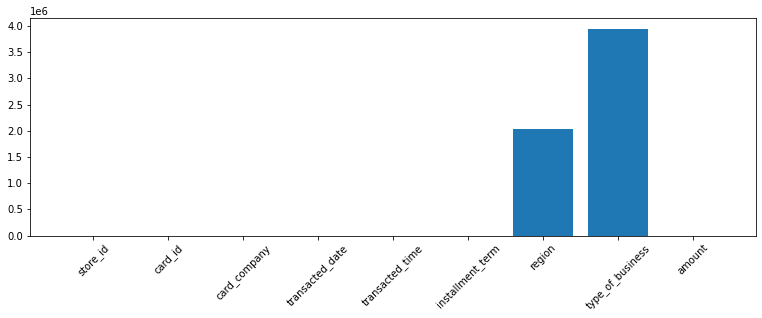

In [5]:
plt.figure(figsize=(13, 4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)

**결측값의 수가 높게 나온 'region' 칼럼과 'type_of_business' 칼럼을 제거한다**

In [6]:
train=train.drop(['region','type_of_business'],axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


## 2. 데이터 전처리

#### **① datetime 칼럼 생성**

In [7]:
train['datetime'] = pd.to_datetime(train.transacted_date + " " + 
                                train.transacted_time, format='%Y-%m-%d %H:%M:%S')

In [8]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


#### **② amount 칼럼 확인 & 노이즈 제거**

<AxesSubplot:xlabel='amount'>

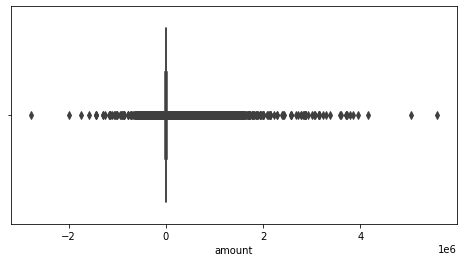

In [9]:
plt.figure(figsize=(8, 4))
sns.boxplot(train['amount'])

In [10]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
41,0,40,a,2016-06-10,17:26,2,-8571.428571,2016-06-10 17:26:00
347,0,285,a,2016-08-04,17:52,0,-1857.142857,2016-08-04 17:52:00
731,0,473,g,2016-10-17,10:32,0,-2000.000000,2016-10-17 10:32:00
831,0,230,b,2016-11-03,15:36,0,-85.714286,2016-11-03 15:36:00
944,0,138,a,2016-11-28,13:21,0,-57.142857,2016-11-28 13:21:00


**amount(거래액) 칼럼에서 보이는 음수값은 환불금액으로 예상된다!**

- 환불한 경우는 log를 취했을 때 무한대 값이 나오기 때문에 제거하는 것이 낫다고 판단했다.
- 환불발생 이전 데이터 중 card_id가 같고 amount의 절댓값이 같은 후보 리스트를 찾은 후, 가장 최근 시간의 것을 제거한다.

In [11]:
## 함수 생성

def refund_remove(df):
    
    # 환불 여부에 따라 데이터 나누기
    refund=df[df['amount']<0]
    non_refund=df[df['amount']>0]
    remove_data=pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()):
        divided_data=non_refund[non_refund['store_id']==i] # non_refund 스토어 데이터를 스토어별로 나누기
        divided_data2=refund[refund['store_id']==i] # refund 스토어 데이터를 스토어별로 나누기
        
        for neg in divided_data2.to_records()[:]: # 환불데이터를 차례대로 검사
            refund_store=neg['store_id']
            refund_id=neg['card_id'] # 환불 카드 아이디
            refund_datetime=neg['datetime'] # 환불 시간
            refund_amount=abs(neg['amount']) # 환불액에 절대값 씌운 것
                
            # 환불시간 이전의 데이터중 카드아이디와 환불액이 같은 후보 리스트 뽑기
            refund_pay_list=divided_data[divided_data['datetime']<=refund_datetime]
            refund_pay_list=refund_pay_list[refund_pay_list['card_id']==refund_id]
            refund_pay_list=refund_pay_list[refund_pay_list['amount']==refund_amount]
                
                
            # 후보리스트가 있으면 카드아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime=max(refund_pay_list['datetime']) # 가장 최근 시간을 구한기
                remove=divided_data[divided_data['datetime']==refund_datetime] # 가장 최근시간
                remove=remove[remove['card_id']==refund_id] # 환불 카드 아이디
                remove=remove[remove['amount']==refund_amount] # 환불액
                divided_data=divided_data.drop(index=remove.index) # 인덱스를 통해 제거
                    
        # 제거한 데이터를 데이터프레임에 추가
        remove_data=pd.concat([remove_data,divided_data],axis=0)
    
    return remove_data

In [12]:
train_remove=refund_remove(train)

100%|██████████| 1967/1967 [13:18<00:00,  2.46it/s]


<AxesSubplot:xlabel='amount'>

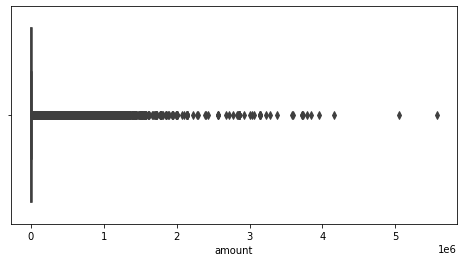

In [13]:
plt.figure(figsize=(8, 4))
sns.boxplot(train_remove['amount'])

**환불금액이 잘 제거되었다!**

#### **③ 다운샘플링**

In [14]:
## 월별로 다운 샘플링해주는 함수 생성

def month_resampling(df):
    
    new_data=pd.DataFrame() 
    df['year_month']=df['transacted_date'].str.slice(stop=7)
    year_month=df['year_month'].drop_duplicates() # 중복값을 drop한다!
    
    downsampling_data=df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data=pd.DataFrame(downsampling_data)
    downsampling_data=downsampling_data.reset_index(drop=False,inplace=False)
    
    for i in tqdm(df.store_id.unique()):
        
        store=downsampling_data[downsampling_data['store_id']==i]
        start_time=min(store['year_month'])
        store=store.merge(year_month,how='outer')
        store=store.sort_values(by=['year_month'], axis=0, ascending=True) # 데이터를 시간순으로 정렬
        
        store['amount']=store['amount'].fillna(2)   # 매출이 발생하지 않는 월은 2로 채우기
        store['store_id']=store['store_id'].fillna(i) # store_id 결측치 채우기
        store=store[store['year_month']>=start_time]  # 매출 시작일 이후만 뽑기
        
        new_data=pd.concat([new_data,store],axis=0)
        
    return new_data

In [15]:
# 월별로 데이터 다운샘플링 시행

resampling_data=month_resampling(train_remove)
resampling_data['store_id']=resampling_data['store_id'].astype(int)
pd.set_option('display.float_format', '{:.2f}'.format)
resampling_data

100%|██████████| 1967/1967 [00:08<00:00, 223.12it/s]


,store_id,year_month,amount
0,0,2016-06,747000.00
1,0,2016-07,1005000.00
2,0,2016-08,869714.29
3,0,2016-09,897857.14
4,0,2016-10,835428.57
...,...,...,...
17,2136,2018-10,2012214.29
18,2136,2018-11,2127642.86
19,2136,2018-12,2427428.57
20,2136,2019-01,1867785.71


#### **④ 상점별 Series 데이터로 변환 & 시각화**

In [16]:
## Series 데이터로 변환해주는 함수 생성

def time_series(df,i):
    
    store=df[df['store_id']==i]
    index=pd.date_range(min(store['year_month']),'2019-03',freq='BM') # 영업 시작일부터 2019년 2월까지 데이터 존재
    ts=pd.Series(store['amount'].values,index=index)
    
    return ts

In [17]:
store_0=time_series(resampling_data,0) # store_id == 0인 경우
store_1=time_series(resampling_data,1) # store_id == 1인 경우
store_2=time_series(resampling_data,2) # store_id == 2인 경우

<AxesSubplot:>

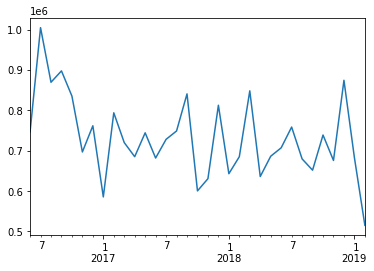

In [18]:
store_0.plot()

<AxesSubplot:>

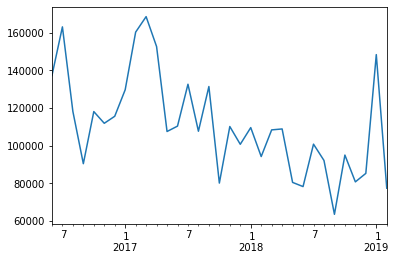

In [19]:
store_1.plot()

<AxesSubplot:>

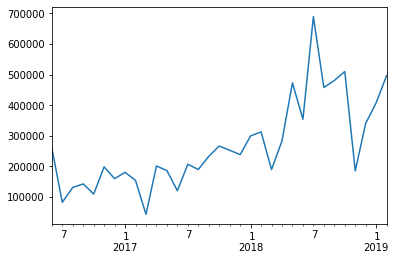

In [20]:
store_2.plot()

## 3. 탐색적 자료분석 (EDA)

#### **① amount 변수 분포 확인**

<AxesSubplot:xlabel='amount', ylabel='Density'>

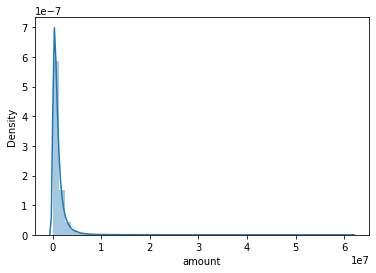

In [21]:
sns.distplot(resampling_data['amount'])

#### **② target 변수의 대칭성(정규성)확인**

Skewness : 0.4819637048612454


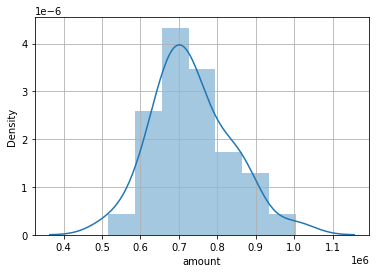

Skewness : 0.5102521050694745


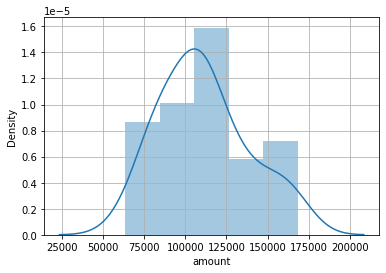

Skewness : 0.9982599271676981


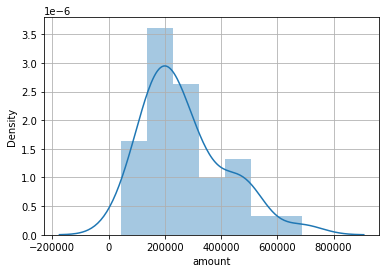

In [22]:
for i in resampling_data.store_id.unique()[:3]:
    print("Skewness :", resampling_data[resampling_data.store_id == i].amount.skew())
    sns.distplot(resampling_data[resampling_data.store_id == i].amount)
    plt.grid()
    plt.show()

#### **③ 각 상점별 매출 그래프**

In [23]:
## 상점 매출 시계열 그래프 출력 함수 생성

def store_plot(data,start_id,end_id):
    
    plt.figure(figsize=(15, 6))
    
    for i in data['store_id'].unique()[start_id:end_id]:
        plt.plot(data[data['store_id']== i].index, data[data['store_id'] == i].amount, label='store_{}'.format(i))
        
    plt.legend()   

In [24]:
## 상점별 매출 분포 출력 함수 생성

def store_displot(data,start_id,end_id):
    
    plt.figure(figsize=(15, 6))
    
    for i in data.store_id.unique()[start_id:end_id]:
        sns.distplot(data[data.store_id == i].amount)
        
    plt.grid()
    plt.show()

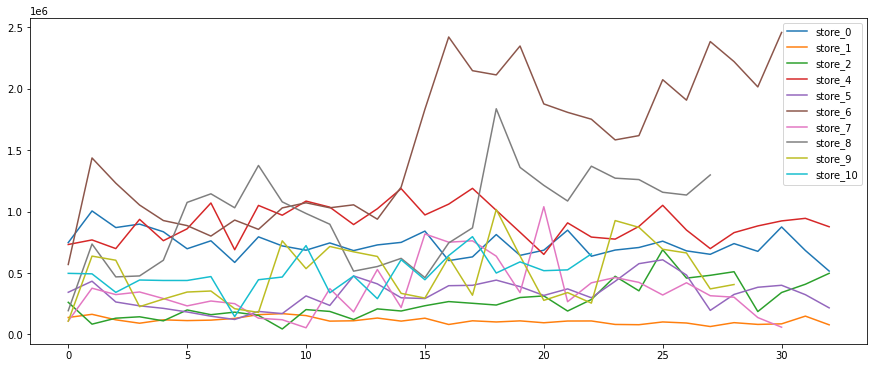

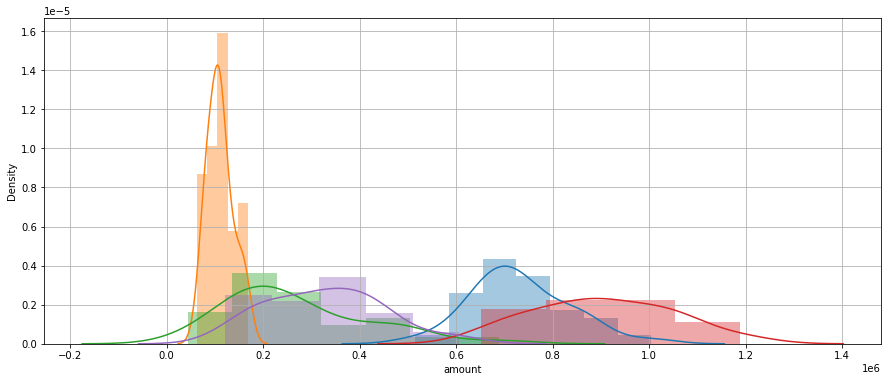

In [25]:
# 그래프 출력

store_plot(resampling_data,0,10)
store_displot(resampling_data,0,5)

**각 상점별 매출 특성과 분포가 다르므로 개별적인 시계열 모델링이 필요해 보인다!**

#### **④ 단위근 검정**

참고: https://otexts.com/fppkr/stationarity.html

- **단위근 검정**: 통계적 검정을 통해 시계열의 정상성 여부를 판정하는 방법


- **정상성**이 있는 시계열은 그 특징이 해당 시계열이 관측된 시간에 무관하다.  즉, 추세나 계절성이 없어서 언제 관찰하는지에 상관 없이 어떤 시점에서 보더라도 똑같이 보인다!


- **차분(differencing)**: 연이은 관측값들의 차이를 계산하는 방법 ( y′(t) = y(t) − y(t−1) )
                     평균이 일정하지 않은 시계열은 차분(difference)을 통해 정상화할 수 있다.
                     
                     
- **확률보행모델**: 정상성을 나타내지 않는 데이터. 누가 봐도 알 수 있는 긴 주기를 갖는 상향 또는 하향 추세가 있고, 갑작스럽고 예측할 수 없는 방향 변화가 있다.

> **귀무가설(H0)**: 자료에 단위근이 존재한다 </br>
**대립가설(H1)**: 시계열 자료가 정상성을 만족한다(또는 추세 정상성을 만족한다)

In [26]:
## ARIMA 모형의 차분 여부를 결정하기 위한 단위근 검정 함수 생성

def adf_test(y):
    
    adf_test = ADFTest(alpha=0.05)
    p_val, should_diff = adf_test.should_diff(y)
    
    return p_val

100%|██████████| 1967/1967 [00:04<00:00, 435.76it/s]


<AxesSubplot:>

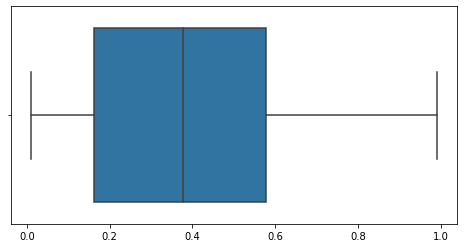

In [27]:
# 전체 상점 adf_test p-value값을 계산하여 boxplot 그려보기

adf_p=[]

for i in tqdm(resampling_data['store_id'].unique()):
    ts=time_series(resampling_data,i)
    adf_p.append(adf_test(ts))
    
plt.figure(figsize=(8, 4))    
sns.boxplot(adf_p)

**대부분의 p-value 값이 0.05보다 높으므로**(유의수준 5%) **귀무가설**(H0:자료에 단위근이 존재한다)**을 채택한다**

**시계열 자료의 정상성을 만족하기 시키기 위해 차분이 필요해 보인다!**

#### **⑤ ACF, PACF 확인**

참고: https://direction-f.tistory.com/65

> **자기상관함수(Autocorrelation Fucntion, ACF)** </br>
: y(t)와 y(t+k) 사이의 correlation을 측정</br></br>
![acf](./image/acf.gif)

</br>

> **편자기상관함수(Partial Autocorrelation Fucntion, PACF)** </br>
: y(t)와 y(t+k) 사이의 correlation을 측정하는 것은 ACF와 동일하나,  t와 t+k 사이에 다른 y값들의 영향력을 배제하고 측정 </br></br>
![pacf](./image/pacf.gif)

</br>

In [28]:
## acf, pacf 그래프 그리는 함수 생성

def acf_pacf_plot(data=None,store_id=None):
    
    ts=time_series(data,store_id)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    plot_acf(ts,lags=15,ax=ax1)
    ax2 = fig.add_subplot(212)
    plot_pacf(ts, lags=15, ax=ax2)

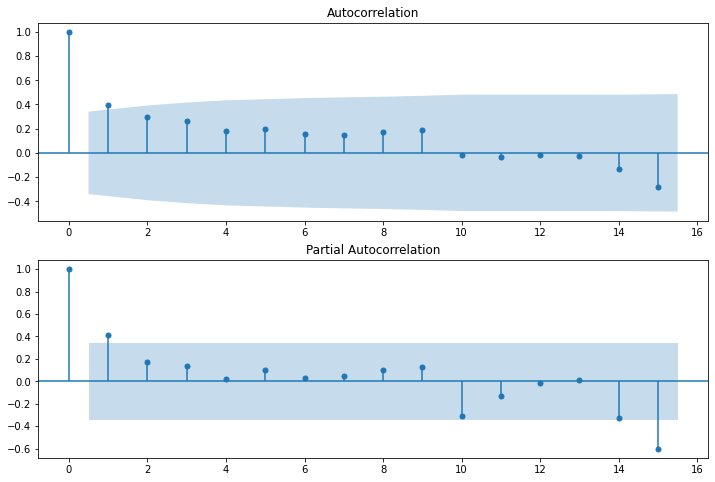

In [29]:
# 상점별로 acf, pacf 그래프 확인

acf_pacf_plot(data=resampling_data,store_id=1)

**ACF의 경우 특정 시점 이후부터 감소하는 형태를, PACF의 경우 특정시점 이후부터 사인함수형태가 나타난다**

![acf](./image/acf_pacf.png)

**위 표**(출처: https://hwao-story.tistory.com/13) **를 참고하여 파라미터를 결정해보면 좋을 것 같다**

## 4. 모델 학습 및 검증

#### **모델 설정**

- 시계열 모델로 모델링을 진행 하기 때문에 year-month 변수와 매출액 변수만 유지한다
- 매출액 오차를 줄이기 위해 auto_arima 모델, stl_descompostion+ets 모델, simple ets 모델을 average 앙상블로 묶자!
- 모델링을 할때 coefficient_variation(매출 변동계수)를 고려해서(0.3 이하인 경우) log 정규화를 진행한다

#### 개념

> **자기회귀누적이동평균모형(ARIMA(p,d,q) 모형)** </br>
AR모형과 MA모형을 합쳐 ARIMA모형으로 정상화할 수 있다, 파라미터 중 p는 AR모형과, q는 MA 모형과 관련이 있다

> **AR(p): 자기회귀모형** </br>
현재값 y(t)를 추측할 때 p개 과거값들의 선형결합으로 예측

> **MR(p): 이동평균모형** </br>
현재값 y(t)를 추측할 때 오차와 q개의 과거오차들의 선형결합으로 예측

> **앙상블** </br>
    여러 개의 모델을 조화롭게 학습시킨 후  그 모델들의 예측 결과들을 이용해 하나의 결과값을 도출해내는 방법
    
#### 함수
> **ts()**: 데이터를 시계열 자료로 변환해주는 함수</br>
**diff()**: ARIMA(p,d,q) 에서 d를 구현하는 함수</br>
**auto.arima()**: 적절한 파라미터로 모델을 구현해주는 함수, AIC를 최소로하는 p, d, q값을 자동적으로 탐색한다</br>

In [30]:
## 매출 변동계수를 구하는 함수

def coefficient_variation(df,i):
    
    cv_data=df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv=cv_data[i]
    
    return cv

In [31]:
hybridModel = """function(testdata){
        library(forecast)
        library(forecastHybrid) # 앙상블 시계열 모델을 쉽게 구축 할 수 있게 해주는 패키지
        d_params=ndiffs(testdata)
        hb_mdl<-hybridModel(testdata,models="aes",
                        a.arg=list(max.p=2,d=d_params),weight="equal") # 파라미터는 ndiffs(d값 계산)함수 이용, max.p=2로 고정
        forecasted_data<-forecast(hb_mdl,h=3) # 이후 3개월(h=3)을 예측
        outdf<-data.frame(forecasted_data$mean)
        colnames(outdf)<-c('amount')
        outdf
    }
"""

#### **예측 수행**

In [32]:
# 사용할 R 함수

hybridModel=robjects.r(hybridModel)
ts=robjects.r('ts')
c=robjects.r('c')
log=robjects.r('log')
exp=robjects.r('exp')

final_pred=[]

for i in tqdm(resampling_data.store_id.unique()):
    pred=[]
    
    store=resampling_data[resampling_data['store_id']==i]
    start_year=int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month=int(min(store['year_month'])[5:]) # 영업 시작 월
    
    cv=coefficient_variation(resampling_data,i)
    
    # 매출액 변동계수가 0.3이하인 경우만 정규화 -> log 씌우기
    if cv<0.3:
        data=ts(log(store['amount']),start=c(start_year,start_month),frequency=12) # R의 ts함수로 time series데이터로 변환
        
        # 앙상블 model
        forecast=hybridModel(data)
        final_pred.append(np.sum(robjects.conversion.rpy2py(exp(forecast)).values)) # 3개월 매출을 합산해서 final_pred에 추가

    else:
        data=ts(store['amount'],start=c(start_year,start_month),frequency=12)
        
        # 앙상블 model
        forecast=hybridModel(data)
        final_pred.append(np.sum(robjects.conversion.rpy2py(forecast).values)) # 3개월 매출을 합산해서 final_pred에 추가 

  0%|          | 0/1967 [00:00<?, ?it/s]R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Loading required package: thief

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  0%|          | 1/1967 [00:01<40:56,  1.25s/it]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  0%|          | 2/1967 [00:01<30:08,  1.09it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  0%|          | 4/1967 [00:01<21:52,  1.50it/s]R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

R[write to console]: Fitting the auto.arima model

R[write to console]: Fitting the ets model

  0%|          | 6/1967 [00:01<15:56,  2.05it/s]R[write to console]: Fit

## 5. 예측 결과 확인

In [33]:
submission['amount']=final_pred
submission.head()

,store_id,amount
0,0,1999469.94
1,1,262835.45
2,2,1268506.54
3,4,2665576.38
4,5,677829.53


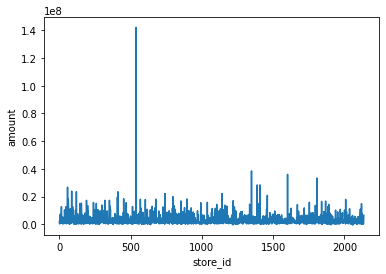

In [34]:
# 예측값으로 plot 그리기

plt.plot(submission['store_id'], submission['amount'])
plt.xlabel('store_id')
plt.ylabel('amount')
plt.show()

## 6. 개선방향 및 느낀점

- 라쏘, 릿지 등의 회귀 모델을 함께 사용해보면 좋을 것 같다
- 한달 단위가 아닌 다른 단위로 리샘플링 하는 것을 고안해볼 필요가 있다
- 데이터 기간이 부족한 상점들은 stl모형을 적합할 수 없어서 아쉬웠는데, 데이터가 더 많은 상황이라면 오차가 개선될 수 있을 것 같다
- 시계열 데이터를 분석할 때는 다른 어떤 데이터들을 다룰 때보다 이론과 개념이 중요하다는 것을 많이 느꼈다
- 개념과 관련된 자료들을 찾아볼 때는 많이 어려웠는데, 코드와 함께 돌려보면서 생각해보니까 이해가 더 잘 된 것 같다
- 개인적으로 tqdm이라는 좋은 모듈을 알게되어서 매우 기쁘다

## 7. 참고

- https://dacon.io/competitions/official/140472/codeshare/953?page=1&dtype=recent
- https://otexts.com/fppkr/stationarity.html
- https://data-newbie.tistory.com/38
- https://blog.naver.com/jiyong615/222128106400
- https://www.opentutorials.org/module/4404/27009
- https://hwao-story.tistory.com/13
